In [1]:
# All imports and setups 

%run ../../common/import_all.py

import sys
sys.path.append('../../')

import statsmodels.api as sm
from scipy.spatial.distance import euclidean

from common.setup_notebook import *

config_ipython()
setup_matplotlib()
set_css_style()

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# The Gradient Descent method

The Gradient Descent is a general mathematical optimization method used to minimize functions in the form of a sum: 

$$f(w) = \sum_i^n f_i(w) \ .$$ 

This method lies at the core of the mathematical tools used in Machine Learning. For instance, in a Linear Regression task, in the Ordinary Least Squares implementation, the function to be minimized (error function) is the one describing the sum of squared residuals between the observed value and the value predicted by the fitting line, over all observations: 

$$E[\bar w] = \sum_i^n (y_i - \bar w \cdot x_i)^2 \ .$$

Here (sum goes over all observations in the dataset), w is the vector of parameters of the line, the dot product is intended to assume a value of 1 for observational independent variable x, so that we would have the slope and the intercept of the line as parameters, in the parameters vector; y is the actual observed dependent variable. The Gradient Descent method is a first order optimization method in that it deals with the first derivative of the function to be minimized. The gradient of the function is indeed used to identify the direction of maximum growth of the function, hence a descent is implemented, whereby the parameters get, starting from an initial state, diminished following the updating rule: 

$$w := w - \alpha \nabla f(w) = w - \alpha \nabla \left( \sum_i^n f_i(w) \right) \ .$$ 

At each iteration step, a Standard Gradient Descent needs to update the parameters by computing the gradient considering all training points in the dataset.
The value multiplying the gradient is the learning rate chosen to perform the update. Clearly, a too big learning rate might get us past the minumum we want to reach, trapping us in a zig-zagging path across it. On the other hand, a value of the learning rate which is very small would slow down the computation.
The iteration will stop once the difference between the current value of the parameter and the previous one falls below a given precision threshold.

This method is also typically called the *standard* gradient descent, to distinguish it from the *stochastic* variant, which we'll describe later on.

## Standard Gradient Descent: finding the minumum of a function

<img style="float: right;" src="../../imgs/vectorfield.jpg">

Suppose we want to use the (standard) Gradient Descent method to minimize a function. Given a paraboloid

$$f(x, y) = x^2 + y^2 \ ,$$

the vector field given by its gradient is graphically represented as per figure (vector lengths are scaled).

Obviously we know, from calculus, that the (global) minimum will be in the origin. The gradient vector field is furnishing the direction of maximum growth of the paraboloid, hence a descent (a negative sign in the parameter update) will lead us towards the desired minimum.

In the following part, we will code the a Gradient Descent towards the minumum of a 1D parabola from a starting point $x = 7$ and using a learning rate equal to $10^{-1}$. The computation is stopped when the difference between the iteration updates was below a threshold value for the precision set to $10^{-4}$.

### Minimizing a 1D parabola with Standard Gradient Descent

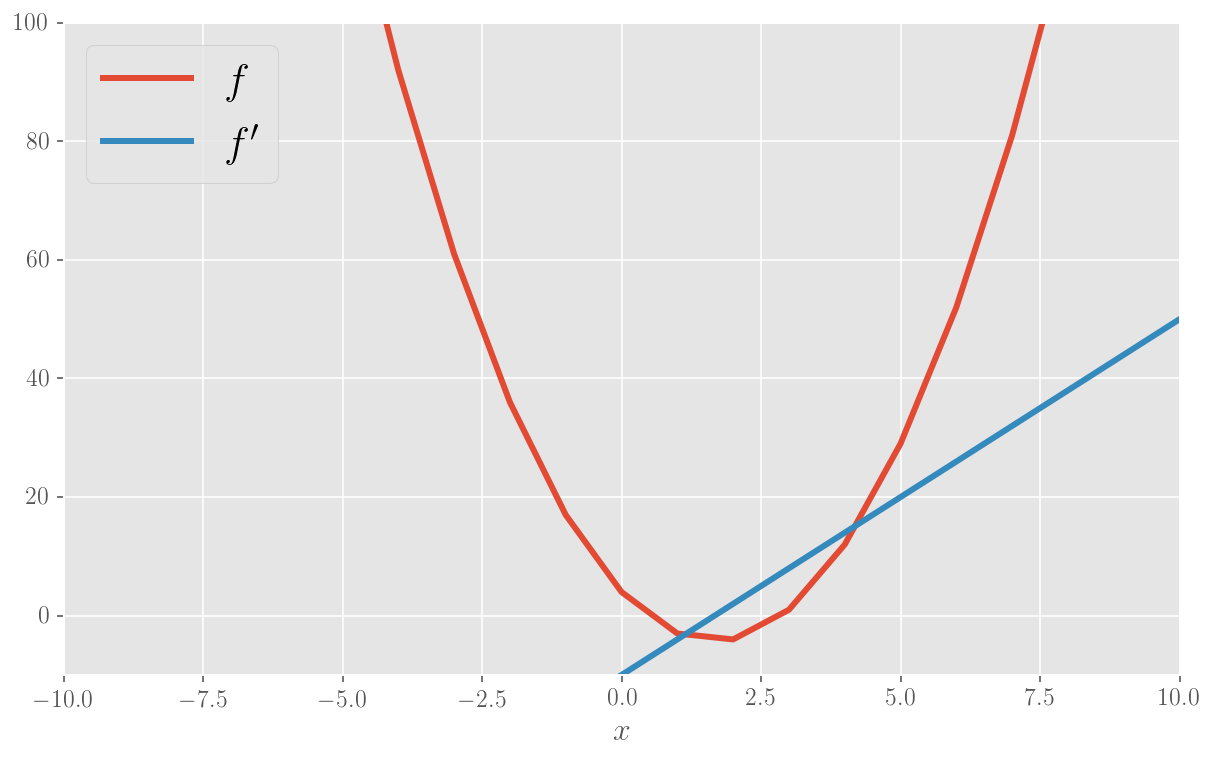

Local min of function is 1.666702


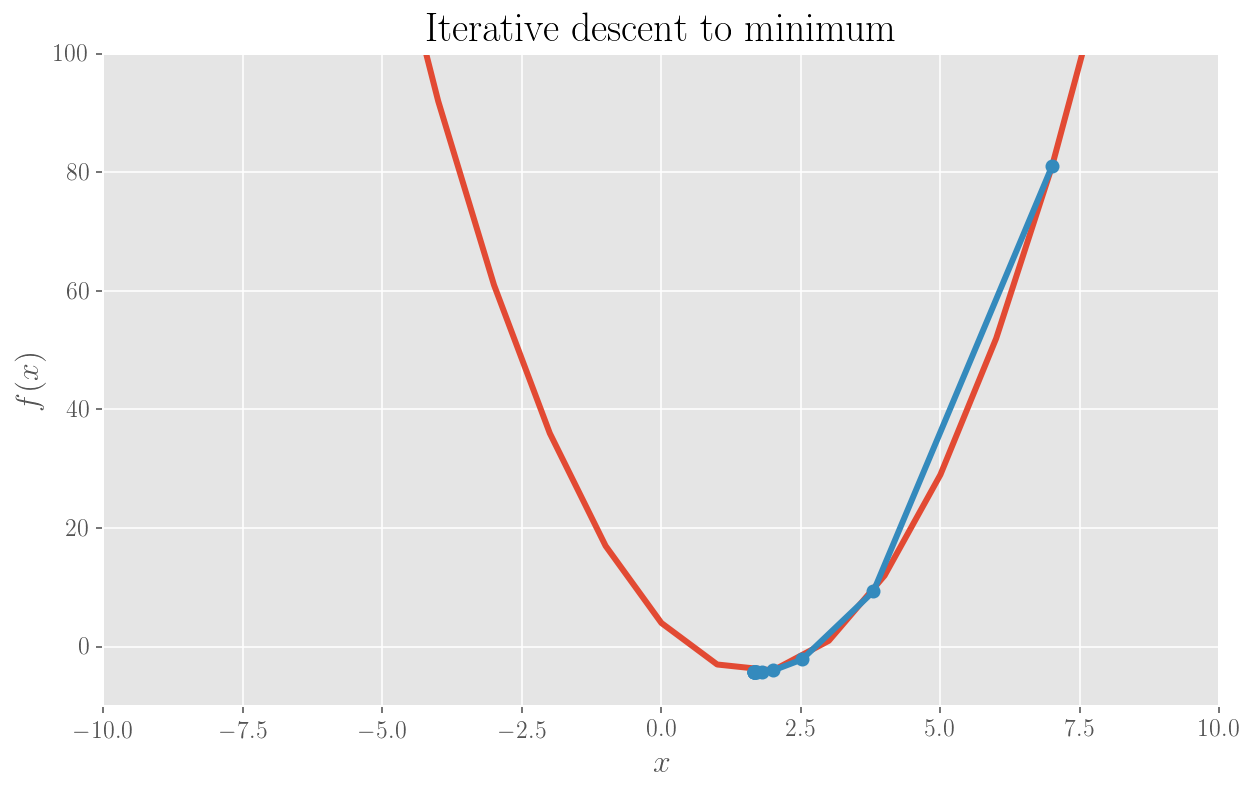

In [3]:
# Choose the x points
x = np.array([i for i in range(-1000, 1000)])

# Define the function and its derivative
def f1(x):
    return 3*x**2 - 10*x + 4

def f1_der(x):
    return 6*x - 10

# Plot the function
plt.ylim(-10,100)
plt.xlim(-10,10)
plt.plot(x, f1(x), label='$f$', lw=3)
plt.plot(x, f1_der(x), label="$f'$", lw=3)
plt.legend(loc=2)
plt.xlabel('$x$')
plt.show()

# Running the Gradient Descent

x0 = 7                                 # starting point for the descent
alpha = .1                             # step size (learning rate)
p = .0001                                # chosen precision

former_min = x0
iterative_mins = [former_min]
while True:
    x_min = former_min - alpha * f1_der(former_min)
    iterative_mins.append(x_min)
    if abs(former_min - x_min) <= p:
        break
    else:
        former_min = x_min
        
print('Local min of function is %f' %x_min)

plt.plot(x, f1(x), lw=3)
plt.ylim(-10,100)
plt.xlim(-10,10)
plt.title('Iterative descent to minimum')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.plot(iterative_mins, f1(np.array(iterative_mins)), marker='o')
plt.show();

### Minimizing a 2D parabola with Standard Gradient Descent

The we do the same but for a paraboloid in 3 dimensions.

In [4]:
def f2(x, y):
    return x**2 + y**2

def f2_der(x, y):
    return np.array([2*x, 2*y])

#Running the Gradient Descent

x0 = 50                                # starting point for the descent
y0 = 50                                # starting point for the descent
alpha = .1                             # step size (learning rate)
p = .0001                              # chosen precision

former_min = np.array([x0, y0])
iterative_mins = [former_min]
while True:
    x_min = former_min - alpha * f2_der(former_min[0], former_min[1])
    iterative_mins.append(x_min)
    if abs(former_min[0] - x_min[0]) <= p and abs(former_min[1] - x_min[1]) <= p:
        break
    else:
        former_min = x_min
        
print('Local min of function is', x_min)

Local min of function is [ 0.00036538  0.00036538]


## Standard Gradient Descent: implementing a Linear Regression

As we said, this method is used in a Ordinary Least Squares calculation in a Linear Regression to find the line which best fits a series of observation points. Let's "manually" implement it.

### Minimizing an objective function for Linear Regression with Standard Gradient Descent

In [5]:
# The experimental points (observations)
x = np.array([1, 2, 2.5, 3, 3.5, 4.5, 4.7, 5.2, 6.1, 6.1, 6.8])
y = np.array([1.5, 1, 2, 2, 3.7, 3, 5, 4, 5.8, 5, 5.7])

alpha = 0.001                       # learning rate
p = .001                            # precision

def f(x, w):
    """A line y = wx, to be intended as w0 + w1x (x0 = 1)"""
    return np.dot(x, w)

def diff(a, b):
    return a - b

def squared_diff(a, b):
    return (a - b)**2

def obj_f(w, x, y):
    """The objective function: sum of squared diffs between observations and line predictions"""
    return sum([squared_diff(f(np.array([1, x[i]]), w), y[i]) for i in range(len(x))])

Found parameters (intercept, slope): [ 0.26961873  0.79783026]


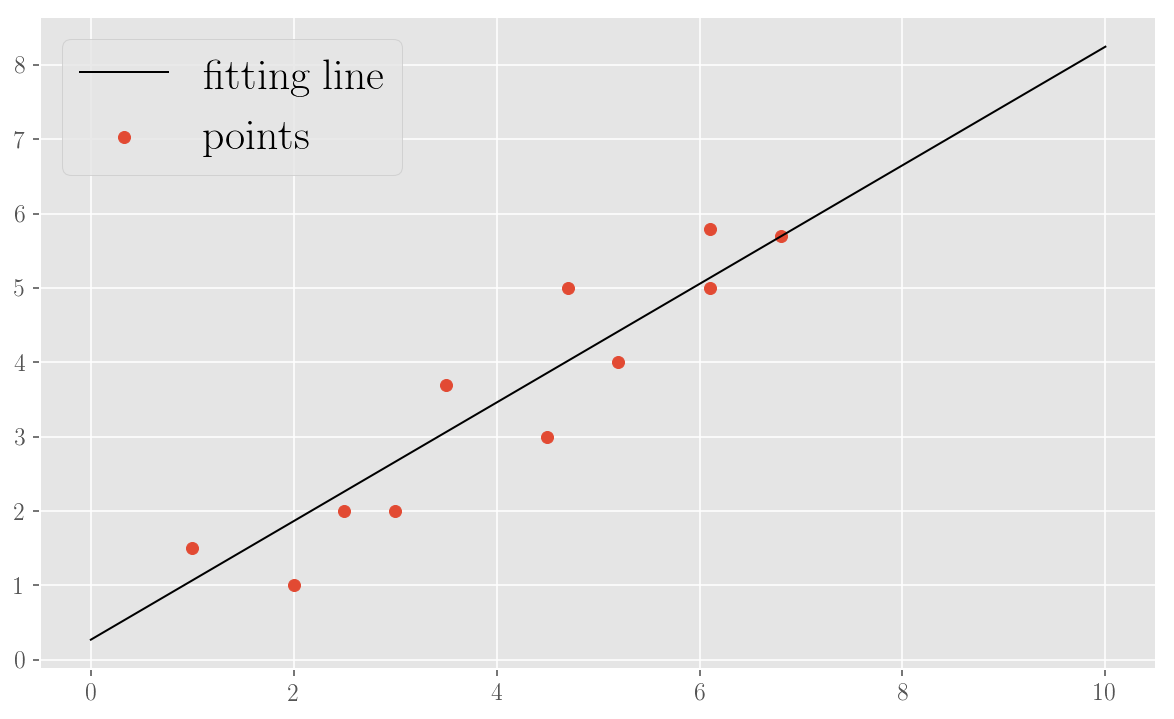

In [6]:
def obj_f_der(w, x, y):
    """Gradient of the objective function in the parameters"""
    return sum([np.dot(2 * np.array([1, x[i]]), diff(f(np.array([1, x[i]]), w), y[i])) for i in range(len(x))])

# Perform a Standard Gradient Descent to get the parameters of the fitting line
former_w = np.array([10, 5])    # the chosen starting point for the descent
while True:
    w = former_w - alpha * obj_f_der(former_w, x, y)
    if euclidean(former_w, w) <= p:
        break
    else:
        former_w = w
    
print('Found parameters (intercept, slope):', w)

plt.scatter(x, y, marker='o', label='points')
plt.plot([i for i in range(0,11)], [w[0] + w[1] * i for i in range(0, 11)], label='fitting line', c='k', lw=1)
plt.legend(loc=2)
plt.show();

## Stochastic Gradient Descent

The stochastic version of the Gradient Descent method does not use all points at each iteration to calculate the gradient of the function but rather picks one point, randomly extracted from the dataset, to compute said gradient. The update of the parameters will then be, at each iteration, 

$$w := w - \alpha \nabla f_i(w)$$ 

A for loop will scroll this rule across all observations in the training set , which has been randomly shuffled (epoch), until the updated parameter does not change by more than chosen precision with respect to the previous one. The Stochastic Gradient Descent will be particularly useful for large datasets where the standard updating rule might be too slow to compute.

### Minimizing an objective function for Linear Regression with Stochastic Gradient Descent

Using the same dataset, same learning rate and same precision as above, we re-implement an OLS, this time using a Stochastic Gradient Descent, and looking at the difference in the result we obtain.

2000
Found parameters (intercept, slope): [ 0.22687683  0.80406405]


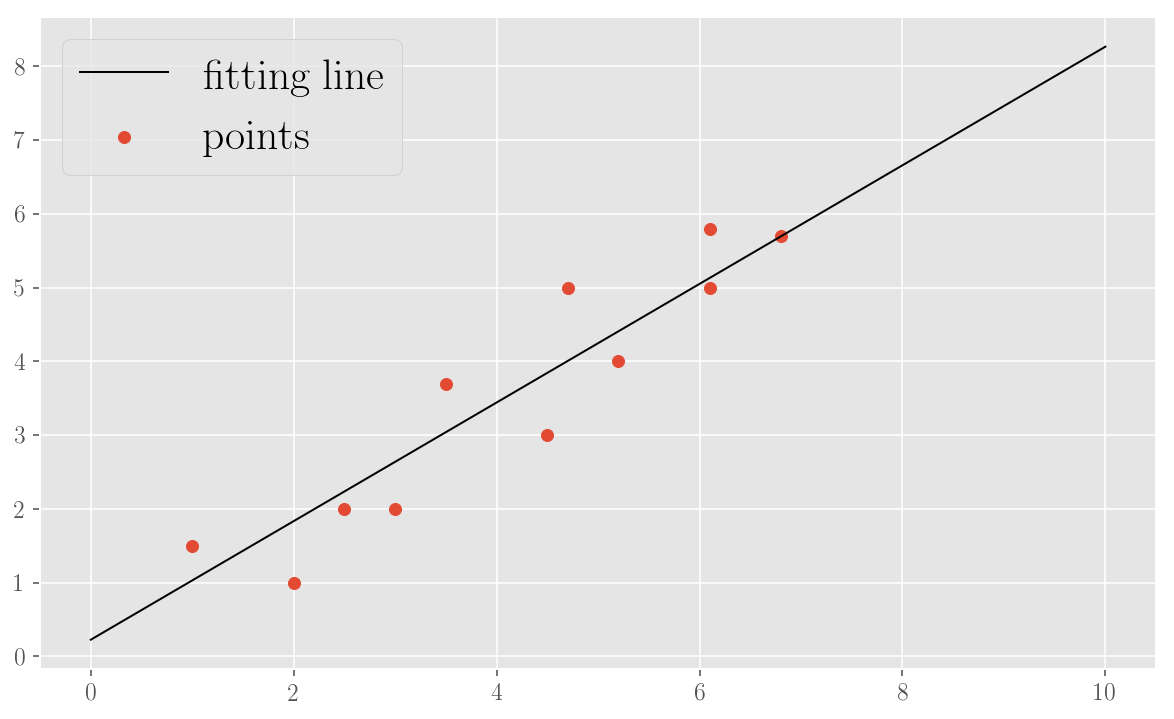

In [7]:
def obj_f_der_point(w, obs_x, obs_y):
    """Addend of the gradient of the objective function in the parameters"""
    return np.dot(2 * np.array([1, obs_x]), diff(f(np.array([1, obs_x]), w), obs_y))

# Perform a Stochastic Gradient Descent to get the parameters of the fitting line
training_set = [(x[i], y[i]) for i in range(len(x))]

epoch = 1
former_w = np.array([10, 5])            # the chosen starting point for the descent
#while epoch < 2000:

found = False
max_epochs = 2000
while epoch < max_epochs:
    random.shuffle(training_set)
    for point in training_set:
        w = former_w - alpha * obj_f_der_point(former_w, point[0], point[1])
        if euclidean(former_w, w) <= p:
            break
        else:
            former_w = w
    
    epoch +=1 
    
print(epoch)
print('Found parameters (intercept, slope):', w)

plt.scatter(x, y, marker='o', label='points')
plt.plot([i for i in range(0,11)], [w[0] + w[1] * i for i in range(0, 11)], label='fitting line', c='k', lw=1)
plt.legend(loc=2)
plt.show();

## Some notes on performance and quality

<img src="../../imgs/gd-featscaling.jpg" width="300" align="right" style="margin:0px 50px"/>

Gradient Descent, when features live on very different scales (for instance if you have, say, the number of seats in a car and its price as features), may be quite slow to converge due to the fact that the parameters will draw very skewed curves. Normalising the features to the same scale, as $\frac{x_i - \mu_i}{\sigma_i}$ will make the procedure faster.

About the learnind rate instead, we said that a too small one will slow down the process but a too big one may make it not converge as the minimum doesn't get hit. The ideal situation is obtained when $E(w)$ goes down monothonically with the number of iterations.

## The Normal Equation

The Normal Equation allows for solving for $w$ analytically, without the need to choose a learning rate and to iterate. What we want to solve is

$$
\frac{\partial E}{\partial w_j} = 0 \ \ \ \forall j \ .
$$

We have the training set in a matrix $X$, where columns are the features and rows the samples, and the target values in a vector $y$. The problem to solve can be written as

$$
\frac{\partial E}{\partial w_j} = 2 \sum_i X^j_i (f_w(x_i) - y_i) \ ,
$$

with $f_w(x_i) = \sum_j w_j X_i^j$. The residuals is expressed as

$$
\sum_k X_{ik} w_k - y_i \ ,
$$

so we can write

$$
\frac{\partial E}{\partial w_j} = 2 \sum_i X_{ij} \sum_k (X_{ik} w_k - y_i) \ \ \ \forall j
$$

which when nullified becomes

$$
\sum_i \sum_k X_{ij} X_{ik} w_k = \sum_i X_{ij y_i} \ \ \ \forall j \ ,
$$

or

$$
\fbox{($X^t$ X) w = X y}
$$

which is the sought *normal equation*, whose parameter solution is 

$$
w = (X^t X)^{-1} X^t y \ .
$$

## References

1. <a name="1"></a> I've explained these same things, in the same way, on my blog [here](https://martinapugliese.github.io/dissecting-the-gradient-descent-method/)
2. <a name="2"></a> The usual [Wikipedia](https://en.wikipedia.org/wiki/Gradient_descent)